I'm planning to build a chat robbot, it would be nice to get familiar to nltk package. 
So in this blog, I will play around with movie titles with their synopses collected from wikipidia and imdb using nltk and sklearn package. 
I use unsupervised learning models to cluster unlabeled documents into different groups, visualize the results and identify their latent topics/structures.

[toc]


## Data

In [3]:
import pandas as pd
import numpy as np

## load crawled data

In [4]:
movies = pd.read_csv('imdb_movies.csv', delimiter=',')
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 238 entries, 0 to 237
Data columns (total 5 columns):
director    213 non-null object
genres      221 non-null object
rating      238 non-null float64
synopsis    238 non-null object
title       238 non-null object
dtypes: float64(1), object(4)
memory usage: 9.4+ KB


For simlicity I dropped the movies whose director or genres are note successfully crawled.

In [25]:
movies.dropna(inplace=True)
movies.reset_index(inplace=True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 199 entries, 0 to 198
Data columns (total 6 columns):
index       199 non-null int64
director    199 non-null object
genres      199 non-null object
rating      199 non-null float64
synopsis    199 non-null object
title       199 non-null object
dtypes: float64(1), int64(1), object(4)
memory usage: 9.4+ KB


Now, we have 199 movies from imdb data. Then we import nltk for text processing, download punctuation and stopwords.

In [6]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/shu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/shu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

### Tokenizing and Stemming

In [18]:
stopwords = nltk.corpus.stopwords.words('english')

In [111]:
from nltk.stem.snowball import SnowballStemmer
import re
stemmer = SnowballStemmer("english")

# tokenization and stemming
def tokenization_and_stemming(text):
    # exclude stop words and tokenize the document, generate a list of string 
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.lower() not in stopwords]

    filtered_tokens = []
    
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.fullmatch('[a-zA-Z]*', token) is not None:
            filtered_tokens.append(token)
            
    # stemming, for example, 'birds'->'bird'
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

# tokenization without stemming (for future use)
def tokenization(text):
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent) if word.lower() not in stopwords]
    filtered_tokens = []
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

## TF-IDF
TF-IDF = TF*IDF

TF(wordA_in_docB) = count of wordA in docB / total words count in docB.

IDF(wordA) = log(total number of documents in the corpus / (number of documents where wordA appears + 1))

In [44]:
from sklearn import decomposition
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [38]:
tfidf_model = TfidfVectorizer(max_df=0.9, max_features=2000,
                                 min_df=0, use_idf=True, tokenizer=tokenization_and_stemming, ngram_range=(1,3))

tfidf_matrix = tfidf_model.fit_transform(movies['synopsis'])

print("In total, there are " + str(tfidf_matrix.shape[0]) + " synoposes and " + str(tfidf_matrix.shape[1]) + " terms.")

In total, there are 199 synoposes and 2000 terms.


## Document similarity

In [41]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(tfidf_matrix)

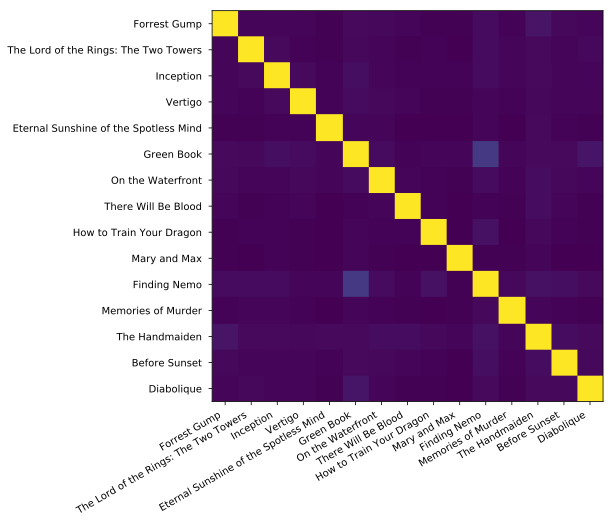

In [63]:
n_movies = 15
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cos_matrix[:n_movies,:n_movies], cmap='viridis')
ax.set_xticks(range(n_movies))
ax.set_yticks(range(n_movies))
ax.set_xticklabels(movies.loc[1:n_movies, 'title'])
ax.set_yticklabels(movies.loc[1:n_movies, 'title'])
fig.autofmt_xdate()

## k-means clustering

In [77]:
# find all genres
genres = {}
for gg in movies.genres:
    for g in gg.strip().split(', '):
        if g not in genres:
            genres[g] = 1
        else:
            genres[g] += 1

In [79]:
print(genres)

{'Drama': 138, 'Romance': 22, 'Adventure': 51, 'Fantasy': 26, 'Action': 31, 'Sci-Fi': 29, 'Thriller': 48, 'Mystery': 28, 'Biography': 18, 'Comedy': 32, 'Music': 5, 'Crime': 39, 'Animation': 17, 'Family': 19, 'Horror': 6, 'War': 24, 'Musical': 4, 'History': 12, 'Film-Noir': 4, 'Western': 7, 'Sport': 5}


The most popular genre is 'Drama'.

In [74]:
from sklearn.cluster import KMeans
# cluster using the number of genres
num_clusters = len(genres)
km = KMeans(n_clusters=num_clusters)
km.fit(tfidf_matrix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=21, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [83]:
movies_clustered = {'title': movies.title, 'genres': movies.genres, 'cluster': km.labels_}
frame = pd.DataFrame(movies_clustered)

In [87]:
frame.head(10)

,title,genres,cluster
0,The Shawshank Redemption,Drama,16
1,Forrest Gump,"Drama, Romance",18
2,The Lord of the Rings: The Two Towers,"Adventure, Drama, Fantasy",8
3,Inception,"Action, Adventure, Sci-Fi, Thriller",18
4,Vertigo,"Mystery, Romance, Thriller",18
5,Eternal Sunshine of the Spotless Mind,"Drama, Romance, Sci-Fi",18
6,Green Book,"Biography, Comedy, Drama, Music",7
7,On the Waterfront,"Crime, Drama, Thriller",15
8,There Will Be Blood,Drama,18
9,How to Train Your Dragon,"Animation, Action, Adventure, Family, Fantasy",18


In [95]:
print(frame.cluster.value_counts())

18    112
11     10
1       8
4       7
13      6
7       6
15      5
8       5
20      4
6       4
17      4
14      4
3       4
5       3
10      3
9       3
16      3
19      2
12      2
2       2
0       2
Name: cluster, dtype: int64


In [94]:
frame[frame.cluster == 18].head(15)

,title,genres,cluster
1,Forrest Gump,"Drama, Romance",18
3,Inception,"Action, Adventure, Sci-Fi, Thriller",18
4,Vertigo,"Mystery, Romance, Thriller",18
5,Eternal Sunshine of the Spotless Mind,"Drama, Romance, Sci-Fi",18
8,There Will Be Blood,Drama,18
9,How to Train Your Dragon,"Animation, Action, Adventure, Family, Fantasy",18
11,Finding Nemo,"Animation, Adventure, Comedy, Family",18
12,Memories of Murder,"Action, Crime, Drama, Mystery, Thriller",18
13,The Handmaiden,"Drama, Romance, Thriller",18
14,Before Sunset,"Drama, Romance",18


Indeed 'Drama' is mostly in cluster 18, which is the most popular cluster.

In [100]:
tf_selected_words = tfidf_model.get_feature_names()

In [103]:
len(tf_selected_words)

2000

In [110]:
km.cluster_centers_

array([[0.00680895, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00293717, 0.00100343, 0.0047483 , ..., 0.00061059, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.0226443 ,
        0.        ],
       ...,
       [0.00324748, 0.00250994, 0.00512131, ..., 0.00228865, 0.00139888,
        0.00363339],
       [0.        , 0.00446349, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00361673, 0.00613169, 0.00286711, ..., 0.00120701, 0.        ,
        0.        ]])

In [118]:
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

Cluster_keywords_summary = {}
for i in range(num_clusters):
    print("Cluster " + str(i) + " words: ", end='')
    Cluster_keywords_summary[i] = []
    for ind in order_centroids[i, :10]:
        Cluster_keywords_summary[i].append(tf_selected_words[ind])
        print(tf_selected_words[ind] + ", ", end='')
    print()
    cluster_movies = frame[frame['cluster']==i]['title'].values.tolist()
    print("Cluster " + str(i) + " titles (" + str(len(cluster_movies)) + " movies): ")
    print(", ".join(cluster_movies))
    print()

Cluster 0 words: tuco, wallac, english, robert, grave, angel, king, eye, coin, bruce, 
Cluster 0 titles (2 movies): 
The Good, the Bad and the Ugly , Braveheart 

Cluster 1 words: nick, chris, barri, regan, neil, ami, gordi, mike, atticus, jem, 
Cluster 1 titles (8 movies): 
The Exorcist , Barry Lyndon , Stand by Me , Gone Girl , The Deer Hunter , Lock, Stock and Two Smoking Barrels , Heat , To Kill a Mockingbird 

Cluster 2 words: toto, dorothi, love, film, town, home, movi, friend, theater, young, 
Cluster 2 titles (2 movies): 
The Wizard of Oz , Cinema Paradiso 

Cluster 3 words: thano, rocket, peter, mile, ronan, gamora, stone, groot, gang, god, 
Cluster 3 titles (4 movies): 
Guardians of the Galaxy , Avengers: Infinity War , Spider-Man: Into the Spider-Verse , City of God 

Cluster 4 words: frank, carl, donni, tommi, harmonica, dave, brendan, jerri, russel, hal, 
Cluster 4 titles (7 movies): 
Catch Me If You Can , Donnie Darko , Up , Fargo , Warrior , 2001: A Space Odyssey , Once 

## Plot k-means results

In [120]:
pca = decomposition.PCA(n_components=2)
tfidf_matrix_np=tfidf_matrix.toarray()
pca.fit(tfidf_matrix_np)
X = pca.transform(tfidf_matrix_np)

xs, ys = X[:, 0], X[:, 1]

#set up cluster names using a dict
cluster_names = {}
for i in range(num_clusters):
    cluster_names[i] = ", ".join(Cluster_keywords_summary[i])

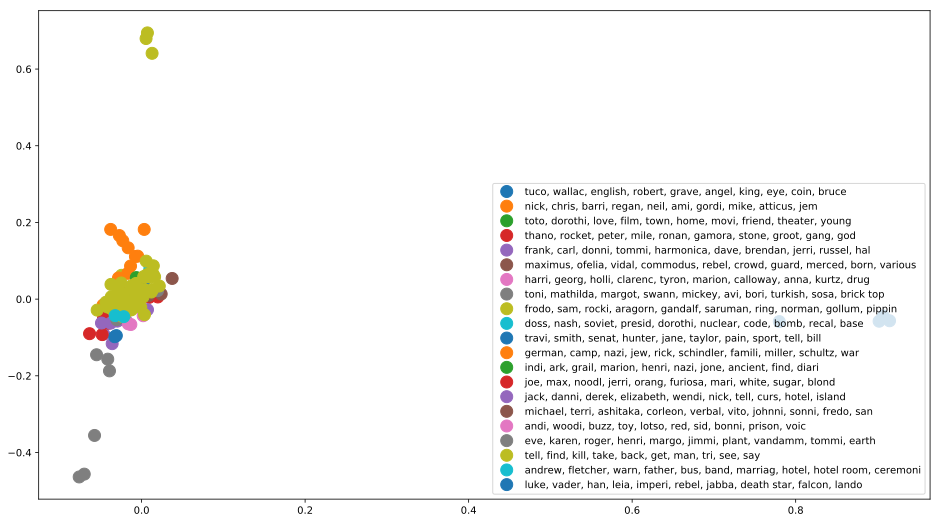

In [130]:
df = pd.DataFrame(dict(x=xs, y=ys, label=km.labels_, title=movies.title)) 
groups = df.groupby(km.labels_)

# set up plot
fig, ax = plt.subplots(figsize=(16, 9))
#Set color for each cluster/group
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=12, 
            label=cluster_names[name])

ax.legend(numpoints=1,loc=4)  #show legend with only 1 point, position is right bottom.

## Latent Dirichlet Allocation

One better way of modeling the topics is Latent Dirichlet Allocation (LDA).

In [134]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=num_clusters, learning_method = 'online')

In [135]:
# LDA requires integer values, keep first 3 digits
tfidf_matrix_lda = (tfidf_matrix * 100)
tfidf_matrix_lda = tfidf_matrix_lda.astype(int)

In [137]:
lda.fit(tfidf_matrix_lda)
topic_word = lda.components_

In [140]:
n_top_words = 10
topic_keywords_list = []
for i, topic_dist in enumerate(topic_word):
    #Here we select top(n_top_words-1)
    lda_topic_words = np.array(tf_selected_words)[np.argsort(topic_dist)][:-n_top_words:-1] 
    topic_keywords_list.append(lda_topic_words.tolist())

In [142]:
doc_topic = lda.transform(tfidf_matrix_lda)
print(doc_topic.shape)

(199, 21)


In [147]:
topic_doc_dict = {}
print("<Document clustering result by LDA>")
for i in range(len(doc_topic)):
    topicID = doc_topic[i].argmax()
    if topicID not in topic_doc_dict:
        topic_doc_dict[topicID] = [movies.title.values[i]]
    else:
        topic_doc_dict[topicID].append(movies.title.values[i])
for i in sorted(topic_doc_dict):
    print("Cluster " + str(i) + " words: " + ", ".join(topic_keywords_list[i]))
    print("Cluster " + str(i) + " titles (" + str(len(topic_doc_dict[i])) + " movies): ")
    print(', '.join(topic_doc_dict[i]))
    print()

<Document clustering result by LDA>
Cluster 0 words: batman, bruce, tommi, sen, bane, gordon, nick, andi, dragon
Cluster 0 titles (12 movies): 
The Shawshank Redemption , How to Train Your Dragon , Donnie Darko , The Deer Hunter , 3 Idiots , Warrior , Room , Batman Begins , Schindler's List , The Dark Knight , The Dark Knight Rises , Spirited Away 

Cluster 1 words: lester, renton, ace, jane, shoe, pair, nicki, mac, ginger
Cluster 1 titles (5 movies): 
The Thing , Trainspotting , Casino , Children of Heaven , American Beauty 

Cluster 2 words: max, marti, joe, noodl, salieri, geeta, samurai, mahavir, mozart
Cluster 2 titles (14 movies): 
Inception , Finding Nemo , Diabolique , Spotlight , The Wolf of Wall Street , Million Dollar Baby , Mad Max: Fury Road , The Treasure of the Sierra Madre , Amadeus , Dangal , Once Upon a Time in America , Sunset Boulevard , Back to the Future , Seven Samurai 

Cluster 3 words: ripley, bike, ami, octavio, alien, keat, ash, dalla, shark
Cluster 3 titles 

The LDA method is obviously giving more evenly distributed topics.